In [2]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns
import pycountry as pc

In [3]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(uni19_df):
    uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
    uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
    uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(uni19_df.loc[:, 'Sending Organization' ]), set(uni19_df.loc[:, 'Receiving Organization']))))
    uni19_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    uni19_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni19_df['Sending Organization']))))
    uni19_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni19_df['Receiving Organization']))))
    # Adjacency matrix
    country_serie = uni19_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))


    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    uni19_df.rename({'Sending Organization': 'source', 'Receiving Organization':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank autority')

    sns.pairplot(scores)
    plt.show()
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank autority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = uni19_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = uni19_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

In [4]:
def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

In [5]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
city_df = pd.read_csv('data\worldcities.csv', sep=',', low_memory=False, header=0, encoding= 'utf8')
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
uni19_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Receiving Country Code']))))
uni19_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Sending Country Code']))))
mob_df = uni19_df.rename(columns={'Sending Organization': 'Source','Receiving Organization': 'Target', 'Participants':'weight', 'Sending Country Code': 'country'})
node_df = mob_df.iloc[:, [15,17]].drop_duplicates(subset='Source')
labels = list(range(0,4339))
node_df['source'] = labels
mob = mob_df.rename(columns={'Source': 'Target'})
node_df1 = mob.iloc[:, [15,17]].drop_duplicates(subset='Target')
node_df1["target"] = labels
results = pd.merge(mob_df,node_df, how='inner', on='Source')
results = pd.merge(results, node_df1, how='inner', on='Target')
edges_df = results.iloc[:, [27,25,23]].groupby(['source','target']).sum()
edges_df.to_csv('edges_universities1.csv')
node = pd.DataFrame()
node['Source'] = mob_df['Source'].unique()
nodes = mob_df.iloc[:, [15,16,17]].drop_duplicates(subset='Source')
#nodes = pd.merge(node,node1,how='left',on='Source').drop_duplicates(subset='Source')
city_df.rename(columns={'city_ascii':'Sending City'}, inplace=True)
city_df['Sending City'] = city_df['Sending City'].str.lower()
nodes['Sending City'] = nodes['Sending City'].str.lower()
city_df = city_df.iloc[:,[1,2,3,7]]
nodes2 = pd.merge(nodes,city_df,how='left',on='Sending City')
nodes2.drop_duplicates(subset='Source', inplace=True)
nodes2['id'] = labels
nodes2.to_csv('nodes_universities1.csv')
nodes2

,country,Sending City,Source,lat,lng,admin_name,id
0,China,beijing,China Foreign Affairs University,39.9050,116.3914,Beijing,0
1,Austria,wien,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,48.2083,16.3731,Wien,1
2,Russian Federation,rostov on don,SOUTHERN FEDERAL UNIVERSITY,NaN,NaN,NaN,2
3,Russian Federation,saint petersburg,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,59.9500,30.3167,Sankt-Peterburg,3
4,Austria,wien,UNIVERSITAT WIEN,48.2083,16.3731,Wien,4
...,...,...,...,...,...,...,...
6185,UK,dunbeg oban,THE SCOTTISH ASSOCIATION FOR MARINESCIENCE LBG,NaN,NaN,NaN,4334
6186,UK,london,BIRKBECK COLLEGE - UNIVERSITY OF LONDON,51.5072,-0.1275,"London, City of",4335
6190,UK,london,IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MED...,51.5072,-0.1275,"London, City of",4336
6194,UK,london,REGENT'S UNIVERSITY LONDON LIMITED,51.5072,-0.1275,"London, City of",4337


In [6]:
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
nodes = np.array(list(set.union(set(uni19_df.loc[:, 'Sending Organization' ]), set(uni19_df.loc[:, 'Receiving Organization']))))
uni19_df.dropna(how='any', inplace=True)
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Source': nodes})
uni19_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni19_df['Sending Organization']))))
uni19_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni19_df['Receiving Organization']))))
# Adjacency matrix
country_serie = uni19_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

In [7]:
import networkx as nx

# G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs, create_using= nx.DiGraph)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

In [8]:
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
df_w_fields = uni19_df.loc[:,['Field of Education','Sending Organization']]
df_w_fields.rename(columns={'Sending Organization':'Source'}, inplace=True)
df_w_fields = pd.merge(df_w_fields,nodes_df,how='inner',on='Source')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not further defined','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', inter-disciplinary programmes','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not elsewhere classified','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(' not elsewhere classified','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not elsewhere classifed','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace('Inter-disciplinary programmes and qualifications involving ','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.lower()
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.strip()
field_dic = {'Education': ['training for pre-school teachers','teacher training without subject specialization','teacher training with subject specialization','education','education science'],
                'Arts and humanities': ['handicrafts','religion and theology','philosophy and ethics','music and performing arts','literature and linguistics','languages','language acquisition','humanities (except languages)','history and archaeology','fine arts','fashion, interior and industrial design','arts', 'arts and humanities', 'audio-visual techniques and media production'],
                'Social sciences, journalism and information': ['sociology and cultural studies','social sciences, journalism and information','social and behavioural sciences','psychology','political sciences and civics','library, information and archival studies','journalism and reporting','journalism and information','economics'],
                'Business, administration and law': ['work skills','wholesale and retail sales','marketing and advertising','management and administration','law','finance, banking and insurance','business, administration and law', 'business and administration', 'accounting and taxation'],
                'Natural sciences, mathematics and statistics': ['statistics','physics','physical sciences','natural sciences, mathematics and statistics','natural environments and wildlife','mathematics and statistics','mathematics','environmental sciences','environment','earth sciences','chemistry', 'biochemistry', 'biological and related sciences', 'biology'],
                'Information and Communication Technologies (ICTs)': ['software and applications development and analysis','information and communication technologies (icts)','database and network design and administration', 'computer use'],
                'Engineering, manufacturing and construction': ['textiles (clothes, footwear and leather)','motor vehicles, ships and aircraft','mining and extraction','mechanics and metal trades','materials (glass, paper, plastic and wood)','manufacturing and processing','food processing','environmental protection technology','electronics and automation','engineering and engineering trades','engineering, manufacturing and construction','electricity and energy','chemical engineering and processes', 'architecture and construction', 'architecture and town planning', 'building and civil engineering'],
                'Agriculture, forestry, fisheries and veterinary': ['veterinary','forestry','fisheries','crop and livestock production', 'agriculture', 'agriculture, forestry, fisheries and veterinary'],
                'Health and welfare': ['welfare','traditional and complementary medicine and therapy','therapy and rehabilitation','pharmacy','nursing and midwifery','medicine','medical diagnostic and treatment technology','hygiene and occupational health services','horticulture','health and welfare','health','dental studies', 'child care and youth services', 'care of the elderly and of disabled adults'],
                'Services': ['travel, tourism and leisure','transport services','sports','social work and counselling','services','security services','secretarial and office work','protection of persons and property','personal services','occupational health and safety','military and defence','hotel, restaurants and catering','hair and beauty services','domestic services','community sanitation']
                }
                
def standard_field(field):
    for f in field_dic.keys():
        if field in field_dic[f]:
            return f

df_w_fields['Field of Education'] = df_w_fields['Field of Education'].apply(standard_field)
df_w_fields['Community']=np.zeros(len(df_w_fields.index),dtype='int8')
df_w_fields['Quantity']=np.ones(len(df_w_fields.index),dtype='int8')

,Field of Education,Source,Community,Quantity
0,"Social sciences, journalism and information",China Foreign Affairs University,0,1
2,Arts and humanities,China Foreign Affairs University,0,1
4,Arts and humanities,China Foreign Affairs University,0,1
8,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,0,1
11,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,0,1
...,...,...,...,...
234346,Services,UNIVERSITY COLLEGE BIRMINGHAM,0,1
234347,"Business, administration and law",UNIVERSITY COLLEGE BIRMINGHAM,0,1
234348,"Business, administration and law",UNIVERSITY COLLEGE BIRMINGHAM,0,1
234349,Services,UNIVERSITY COLLEGE BIRMINGHAM,0,1


,Field of Education,Source,Community,Quantity
5,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
9,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
10,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
15,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
20,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
...,...,...,...,...
5398,"Business, administration and law",VRIJE UNIVERSITEIT BRUSSEL,1,1
5403,"Social sciences, journalism and information",VRIJE UNIVERSITEIT BRUSSEL,1,1
5404,"Business, administration and law",VRIJE UNIVERSITEIT BRUSSEL,1,1
5405,"Social sciences, journalism and information",VRIJE UNIVERSITEIT BRUSSEL,1,1


,Field of Education,Source,Community,Quantity
6,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,2,1
12,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,2,1
17,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,2,1
26,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,2,1
35,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,2,1
...,...,...,...,...
5401,"Social sciences, journalism and information",VRIJE UNIVERSITEIT BRUSSEL,2,1
5407,"Business, administration and law",VRIJE UNIVERSITEIT BRUSSEL,2,1
5410,"Business, administration and law",VRIJE UNIVERSITEIT BRUSSEL,2,1
5413,"Social sciences, journalism and information",VRIJE UNIVERSITEIT BRUSSEL,2,1


,Field of Education,Source,Community,Quantity
3,Arts and humanities,China Foreign Affairs University,3,1
7,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,3,1
34,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,3,1
40,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,3,1
64,Arts and humanities,SOUTHERN FEDERAL UNIVERSITY,3,1
...,...,...,...,...
5211,"Social sciences, journalism and information",FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,3,1
5239,Arts and humanities,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,3,1
5264,Services,SRINAKHARINWIROT UNIVERSITY,3,1
5320,"Engineering, manufacturing and construction",SFAX UNIVERSITY,3,1


,Field of Education,Source,Community,Quantity
50,Arts and humanities,SOUTHERN FEDERAL UNIVERSITY,4,1
80,Services,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,4,1
81,"Social sciences, journalism and information",FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,4,1
83,"Social sciences, journalism and information",FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,4,1
124,Arts and humanities,UNIVERSITAT WIEN,4,1
...,...,...,...,...
5248,"Social sciences, journalism and information",FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,4,1
5251,Information and Communication Technologies (ICTs),FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,4,1
5305,Information and Communication Technologies (ICTs),SFAX UNIVERSITY,4,1
5307,Arts and humanities,SFAX UNIVERSITY,4,1


,Field of Education,Source,Community,Quantity
70,"Social sciences, journalism and information",FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,5,1
294,Arts and humanities,UNIVERSITAT WIEN,5,1
825,"Business, administration and law",UNIVERSITAT WIEN,5,1
1142,"Natural sciences, mathematics and statistics",UNIVERZITET U NOVOM SADU,5,1
1665,"Engineering, manufacturing and construction",UNIVERSITAET FUER BODENKULTUR WIEN,5,1
1709,"Natural sciences, mathematics and statistics",UNIVERSITAET FUER BODENKULTUR WIEN,5,1
1799,"Business, administration and law",FH JOANNEUM GESELLSCHAFT MBH,5,1
2492,"Business, administration and law",UNIVERSITAET INNSBRUCK,5,1
2547,"Social sciences, journalism and information",UNIVERSITAET INNSBRUCK,5,1
2599,"Business, administration and law",UNIVERSITAET INNSBRUCK,5,1


,Field of Education,Source,Community,Quantity
47,"Natural sciences, mathematics and statistics",SOUTHERN FEDERAL UNIVERSITY,6,1
1042,"Natural sciences, mathematics and statistics",UNIVERZITET U NOVOM SADU,6,1
1176,Services,THE HEBREW UNIVERSITY OF JERUSALEM,6,1
1249,Arts and humanities,UNIVERZITET U BEOGRADU,6,1
1366,"Social sciences, journalism and information",UNIVERZITET U BEOGRADU,6,1
1373,"Engineering, manufacturing and construction",UNIVERZITET U BEOGRADU,6,1
2187,Arts and humanities,Tomsk State University,6,1
2253,Arts and humanities,UNIVERZITET U SARAJEVU,6,1
2309,Arts and humanities,UNIVERZITET U SARAJEVU,6,1
2647,Arts and humanities,UNIVERSITAET INNSBRUCK,6,1


,Field of Education,Source,Community,Quantity
68,"Business, administration and law",FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,7,1
527,"Business, administration and law",UNIVERSITAT WIEN,7,1
789,"Social sciences, journalism and information",UNIVERSITAT WIEN,7,1
1147,Information and Communication Technologies (ICTs),UNIVERZITET U NOVOM SADU,7,1
1243,"Business, administration and law",UNIVERZITET U BEOGRADU,7,1
1371,"Engineering, manufacturing and construction",UNIVERZITET U BEOGRADU,7,1
3180,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,7,1
4151,"Social sciences, journalism and information",UNIVERSITE CATHOLIQUE DE LOUVAIN,7,1


,Field of Education,Source,Community,Quantity
1452,"Social sciences, journalism and information",IVAN FRANKO NATIONAL UNIVERSITY OF LVIV,8,1
1929,Arts and humanities,UNIVERSITAET GRAZ,8,1
2229,"Engineering, manufacturing and construction",UNIVERZITET U SARAJEVU,8,1
3379,"Social sciences, journalism and information",THAMMASAT UNIVERSITY,8,1
3583,"Natural sciences, mathematics and statistics",UNIVERSITY OF TEHRAN,8,1
4406,Arts and humanities,M.V. LOMONOSOV MOSCOW STATE UNIVERSITY,8,1
4813,"Business, administration and law",UNIVERSITE DE LIEGE,8,1
5162,"Business, administration and law",FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,8,1


,Field of Education,Source,Community,Quantity
658,Arts and humanities,UNIVERSITAT WIEN,9,1
1044,Arts and humanities,UNIVERZITET U NOVOM SADU,9,1
3234,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,9,1
3449,"Social sciences, journalism and information",PARIS-LODRON-UNIVERSITAT SALZBURG,9,1
3480,Arts and humanities,PARIS-LODRON-UNIVERSITAT SALZBURG,9,1
4246,Arts and humanities,UNIVERSITE CATHOLIQUE DE LOUVAIN,9,1
4703,"Business, administration and law",UNIVERSITE DE LIEGE,9,1


,Field of Education,Source,Community,Quantity
117,"Business, administration and law",UNIVERSITAT WIEN,10,1
404,Arts and humanities,UNIVERSITAT WIEN,10,1
1913,Services,Prince of Songkla University,10,1
2732,Arts and humanities,UNIVERSITAET INNSBRUCK,10,1
3161,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,10,1
5140,"Social sciences, journalism and information",FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,10,1


,Field of Education,Source,Community,Quantity
823,"Business, administration and law",UNIVERSITAT WIEN,11,1
1164,Arts and humanities,THE HEBREW UNIVERSITY OF JERUSALEM,11,1
1290,"Business, administration and law",UNIVERZITET U BEOGRADU,11,1
3019,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,11,1
3174,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,11,1


,Field of Education,Source,Community,Quantity
482,"Business, administration and law",UNIVERSITAT WIEN,12,1
2614,Arts and humanities,UNIVERSITAET INNSBRUCK,12,1
3387,Education,PARIS-LODRON-UNIVERSITAT SALZBURG,12,1
3485,Arts and humanities,PARIS-LODRON-UNIVERSITAT SALZBURG,12,1
4905,"Business, administration and law",UNIVERSITE DE LIEGE,12,1


,Field of Education,Source,Community,Quantity
1035,Arts and humanities,UNIVERZITET U NOVOM SADU,13,1
1883,"Engineering, manufacturing and construction",INSTITUTO TECNOLOGICO Y DE ESTUDIOS SUPERIORES...,13,1
3312,"Business, administration and law",WIRTSCHAFTSUNIVERSITAT WIEN,13,1
4358,"Social sciences, journalism and information",UNIVERSITE CATHOLIQUE DE LOUVAIN,13,1
5218,Arts and humanities,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,13,1


,Field of Education,Source,Community,Quantity
525,"Business, administration and law",UNIVERSITAT WIEN,14,1
1000,"Social sciences, journalism and information",UNIVERZITET U NOVOM SADU,14,1
1694,"Natural sciences, mathematics and statistics",UNIVERSITAET FUER BODENKULTUR WIEN,14,1
2288,"Engineering, manufacturing and construction",UNIVERZITET U SARAJEVU,14,1


,Field of Education,Source,Community,Quantity
304,Arts and humanities,UNIVERSITAT WIEN,15,1
1287,Arts and humanities,UNIVERZITET U BEOGRADU,15,1
1555,"Agriculture, forestry, fisheries and veterinary",UNIVERSITAET FUER BODENKULTUR WIEN,15,1
2305,"Business, administration and law",UNIVERZITET U SARAJEVU,15,1


,Field of Education,Source,Community,Quantity
1451,Arts and humanities,IVAN FRANKO NATIONAL UNIVERSITY OF LVIV,16,1
1917,Arts and humanities,UNIVERSITAET GRAZ,16,1
2546,Arts and humanities,UNIVERSITAET INNSBRUCK,16,1
3801,"Business, administration and law",MCI MANAGEMENT CENTER INNSBRUCK INTERNATIONALE...,16,1


,Field of Education,Source,Community,Quantity
1294,Arts and humanities,UNIVERZITET U BEOGRADU,17,1
3928,Health and welfare,UNIVERSITE CATHOLIQUE DE LOUVAIN,17,1
4060,"Business, administration and law",UNIVERSITE CATHOLIQUE DE LOUVAIN,17,1
4604,Arts and humanities,Yerevan State University,17,1


,Field of Education,Source,Community,Quantity
2126,Arts and humanities,UNIVERSITAET GRAZ,18,1
3525,Arts and humanities,PARIS-LODRON-UNIVERSITAT SALZBURG,18,1
4423,Arts and humanities,M.V. LOMONOSOV MOSCOW STATE UNIVERSITY,18,1
4681,"Business, administration and law",UNIVERSITE DE LIEGE,18,1


,Field of Education,Source,Community,Quantity
855,"Social sciences, journalism and information",UNIVERSITAT WIEN,19,1
1553,Education,Suan Dusit University,19,1
3962,"Business, administration and law",UNIVERSITE CATHOLIQUE DE LOUVAIN,19,1
4844,"Social sciences, journalism and information",UNIVERSITE DE LIEGE,19,1


,Field of Education,Source,Community,Quantity
1656,"Engineering, manufacturing and construction",UNIVERSITAET FUER BODENKULTUR WIEN,20,1
3728,"Business, administration and law",MCI MANAGEMENT CENTER INNSBRUCK INTERNATIONALE...,20,1
4873,"Business, administration and law",UNIVERSITE DE LIEGE,20,1
4956,"Engineering, manufacturing and construction",UNIVERSITE DE LIEGE,20,1


,Field of Education,Source,Community,Quantity
1297,"Engineering, manufacturing and construction",UNIVERZITET U BEOGRADU,21,1
2137,"Business, administration and law",UNIVERSITAET GRAZ,21,1
2503,"Business, administration and law",UNIVERSITAET INNSBRUCK,21,1
5061,"Social sciences, journalism and information",UNIVERSITE DE YAOUNDE I,21,1


,Field of Education,Source,Community,Quantity
1724,"Business, administration and law",FH JOANNEUM GESELLSCHAFT MBH,22,1
4066,"Engineering, manufacturing and construction",UNIVERSITE CATHOLIQUE DE LOUVAIN,22,1
5125,"Social sciences, journalism and information",FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,22,1
5286,"Natural sciences, mathematics and statistics",SFAX UNIVERSITY,22,1


4338


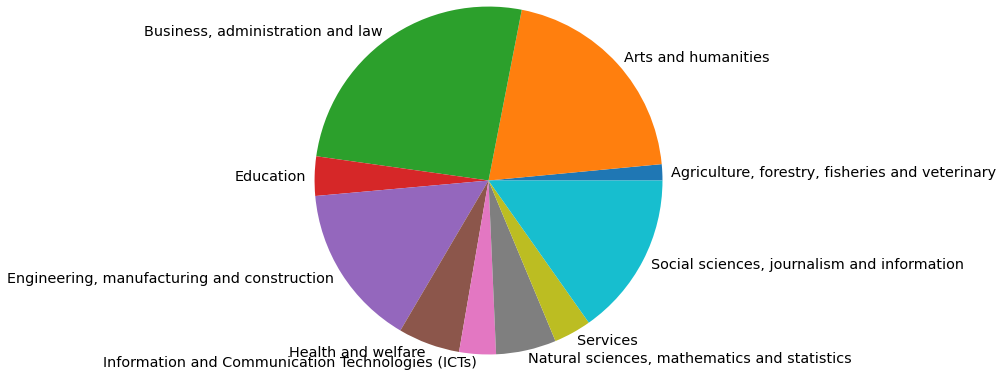

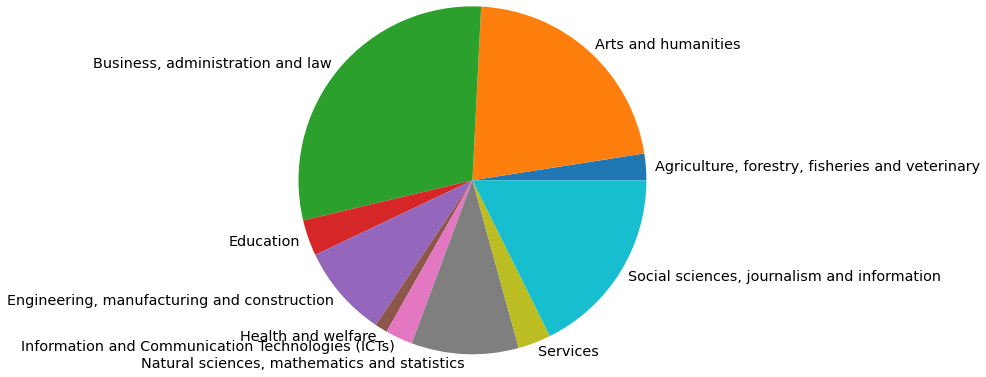

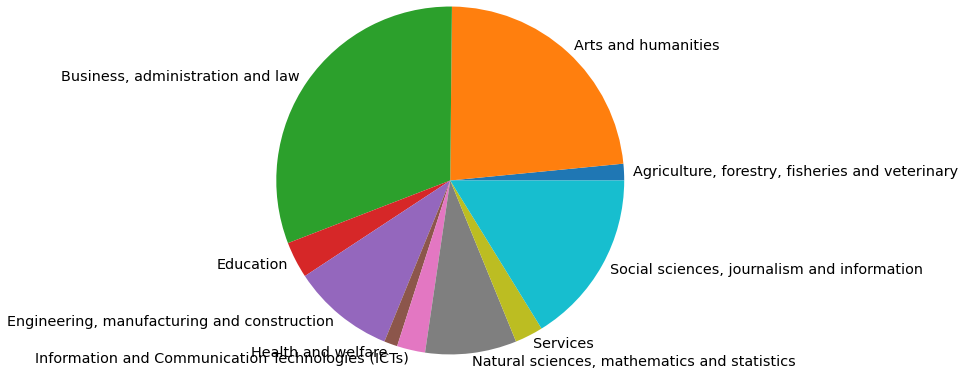

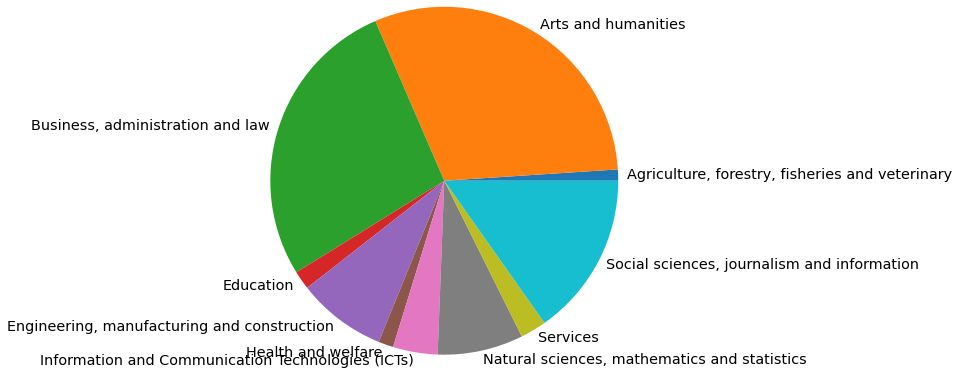

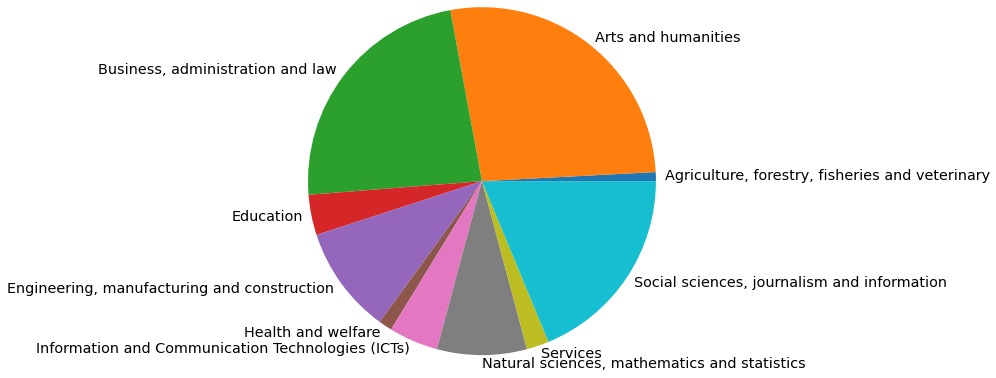

In [9]:
for i, set in enumerate(p):
    for element in set:
        df_w_fields.iat[element, 2]=i
for i, set in enumerate(p):
    if(len(df_w_fields[df_w_fields['Community']==i].index)>3):
        display(df_w_fields[df_w_fields['Community']==i])
print(df_w_fields['Source'].nunique())


for i, set in enumerate(p):
    if(len(df_w_fields[df_w_fields['Community']==i].index)>100):
        com_df = df_w_fields[df_w_fields['Community']==i]
        label = com_df.groupby(['Field of Education']).sum().index.get_level_values('Field of Education').tolist()
        com_df = com_df.groupby(['Field of Education']).sum()
        #display(com_df)
        values = com_df['Quantity']
        #com_df = com1_df['Quantity']/1318*100
        plt.pie(values,labels= label, labeldistance=1.05,radius=2, textprops={'size':'x-large'})
        plt.show()

,country,Sending City,Source,Community,Quantity
1,Austria,wien,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,0,1
7,Serbia,novi sad,UNIVERZITET U NOVOM SADU,0,1
11,Austria,wien,Fachhochschule Technikum Wien,0,1
13,Austria,wien,UNIVERSITAET FUER BODENKULTUR WIEN,0,1
16,Austria,graz,FH JOANNEUM GESELLSCHAFT MBH,0,1
...,...,...,...,...,...
4319,Slovakia,trnava,Univerzita sv. Cyrila a Metoda v Trnave,0,1
4320,Turkey,ankara,ANKARA HACI BAYRAM VELI UNIVERSITESI,0,1
4323,Turkey,serdivan,SAKARYA UYGULAMALI BILIMLER UNIVERSITESI,0,1
4324,Turkey,isparta,Isparta Uygulamali Bilimler Universitesi,0,1


,country,Sending City,Source,Community,Quantity
4,Austria,wien,UNIVERSITAT WIEN,1,1
9,Serbia,beograd,UNIVERZITET U BEOGRADU,1,1
10,Ukraine,lviv,IVAN FRANKO NATIONAL UNIVERSITY OF LVIV,1,1
27,Austria,graz,UNIVERSITAET GRAZ,1,1
30,Bosnia and Herzegovina,sarajevo,UNIVERZITET U SARAJEVU,1,1
...,...,...,...,...,...
4298,Poland,włocławek,Panstwowa Uczelnia Zawodowa we Wloclawku,1,1
4311,Portugal,lisboa,INSTITUTO UNIVERSITARIO DE LISBOA,1,1
4321,Turkey,istanbul,BOGAZICI UNIVERSITESI,1,1
4322,Turkey,konya,KONYA TEKNIK UNIVERSITESI,1,1


,country,Sending City,Source,Community,Quantity
151,Czechia,ostrava,OSTRAVSKA UNIVERZITA,2,1
209,Germany,saarbrücken,Hochschule der Bildenden Künste Saar,2,1
210,Germany,koethen,HOCHSCHULE ANHALT,2,1
217,Germany,alfter,Alanus Hochschule gGmbH,2,1
219,Germany,berlin,Berlin International University of Applied Sci...,2,1
...,...,...,...,...,...
4275,Italy,napoli,Conservatorio San Pietro a Majella,2,1
4276,Italy,siena,"Istituto Superiore di Studi Musicali ""Rinaldo ...",2,1
4277,Italy,san domenico di fiesole fi,FONDAZIONE SCUOLA DI MUSICA DI FIESOLE ONLUS,2,1
4290,Poland,krakow,AKADEMIA MUZYCZNA IM. KRZYSZTOFA PENDERECKIEGO...,2,1


,country,Sending City,Source,Community,Quantity
53,Montenegro,podgorica,University of Donja Gorica,3,1
57,Austria,leoben,MONTANUNIVERSITAT LEOBEN,3,1
58,Ukraine,dnipropetrovsk,NATIONAL MINING UNIVERSITY,3,1
160,Belarus,mogilev,Educational Establishment Mogilev State A.Kule...,3,1
185,Serbia,niš,University of Nis,3,1
...,...,...,...,...,...
4205,France,rennes,OGEC Jean PaulII de la Salle,3,1
4239,Iceland,borgarnes,HASKOLINN A BIFROST SES,3,1
4274,Italy,benevento,Scuola Superiore per Mediatori Linguistici - I...,3,1
4279,Latvia,riga,National Defence Academy of Latvia,3,1


,country,Sending City,Source,Community,Quantity
36,Ukraine,chernivtsi,CHERNIVTSI NATIONAL UNIVERSITY YURIY FEDKOVYCH,4,1
41,Austria,wien,PADAGOGISCHE HOCHSCHULE WIEN,4,1
123,Ukraine,kyiv,NATIONAL DRAGOMANOV PEDAGOGICAL UNIVERSITY OF ...,4,1
126,Ukraine,lviv,HIGHER EDUCATIONAL ESTABLISHMENT UKRAINIAN CAT...,4,1
135,Bulgaria,sofia,SOFIISKI UNIVERSITET SVETI KLIMENT OHRIDSKI,4,1
...,...,...,...,...,...
4136,Spain,valencia,CENTRO UNIVERSITARIO EDEM,4,1
4175,France,pau,Ecole supérieure d'art et de design des Pyrénées,4,1
4283,North Macedonia,sveti nikole,"Megjunaroden Slavjanski Univerzitet ""Gavrilo R...",4,1
4286,Norway,trondheim,DRONNING MAUDS MINNE HØGSKOLE FOR BARNEHAGELÆR...,4,1


,country,Sending City,Source,Community,Quantity
798,Albania,tirana,UNIVERSITY OF NEW YORK TIRANA,5,1
829,France,nice,Communauté d'universités et établissements Uni...,5,1
1328,Turkey,dragos kartal istanbul,ISTANBUL SEHIR UNIVERSITESI,5,1
1354,Albania,tirana,Luarasi University,5,1


,country,Sending City,Source,Community,Quantity
358,Albania,tirana,UNIVERSITETI I MJEKESISE TIRANE,6,1
447,Belarus,vitebsk,Vitebsk State Academy of Veterinary Medicine,6,1
1025,Lithuania,kaunas,LIETUVOS SVEIKATOS MOKSLU UNIVERSITETAS,6,1
1027,"Moldova, Republic of",chisinau,UNIVERSITATEA DE STAT DE MEDICINA SI FARMACIE ...,6,1
1848,Germany,hannover,STIFTUNG TIERAERZTLICHE HOCHSCHULE HANNOVER,6,1
2632,France,toulouse,ECOLE NATIONALE VETERINAIRE DE TOULOUSE,6,1
2862,Hungary,budapest,ALLATORVOSTUDOMANYI EGYETEM,6,1
3072,Ukraine,chernivtsi,Higher State Educational Establishment of Ukra...,6,1
3166,Ukraine,kharkiv,National University of Pharmacy,6,1
3624,Romania,iasi,UNIVERSITATEA DE MEDICINA SI FARMACIE GRIGORE ...,6,1


,country,Sending City,Source,Community,Quantity
215,Germany,neuendettelsau,Augustana-Hochschule,7,1
3298,Norway,oslo,DET TEOLOGISKE MENIGHETSFAKULTET,7,1
3641,Romania,cluj-napoca,Protestant Theological Institute of Cluj-Napoca,7,1
4228,Hungary,sárospatak,Sárospataki Református Teológiai Akadémia,7,1
4229,Hungary,budapest,Evangélikus Hittudományi Egyetem,7,1


,country,Sending City,Source,Community,Quantity
1051,Latvia,riga,INFORMACIJAS SISTEMU MENEDZMENTA AUGSTSKOLA SIA,22,1
1052,Ukraine,kharkiv,SIMON KUZNETS KHARKIV NATIONAL UNIVERSITY OF E...,22,1
1053,Ukraine,cherkasy,Cherkasy state business-college,22,1
4154,Spain,puerto de la cruz,Escuela Superior de Turismo iriarte,22,1


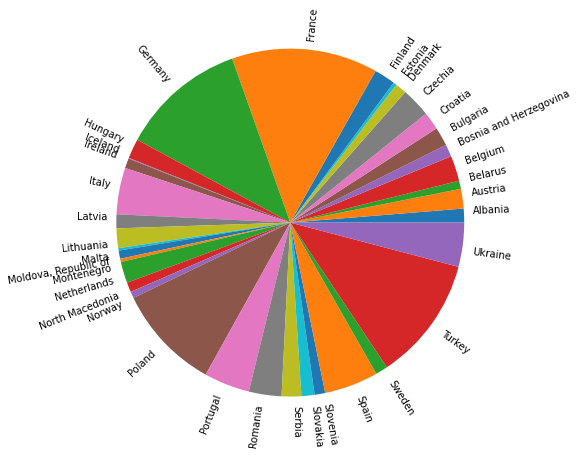

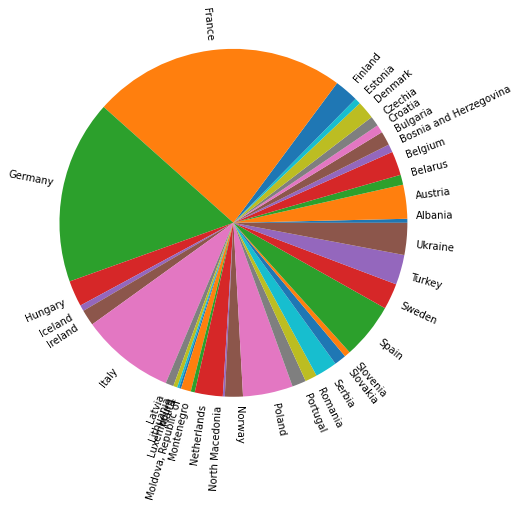

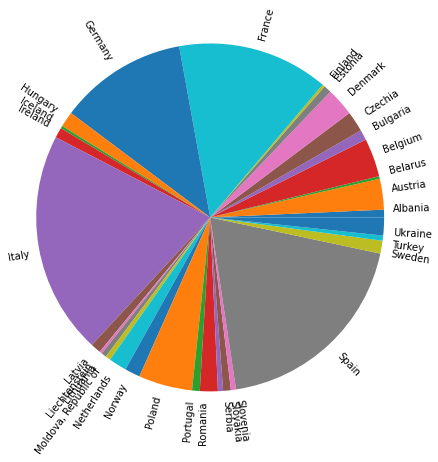

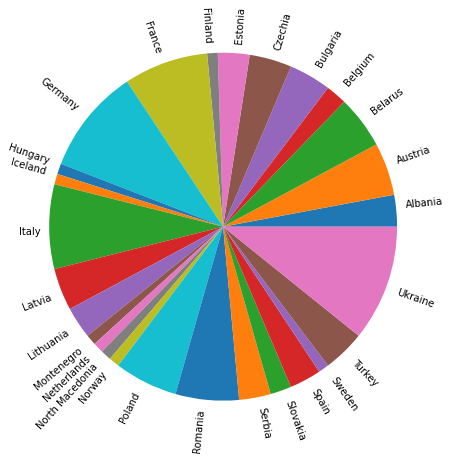

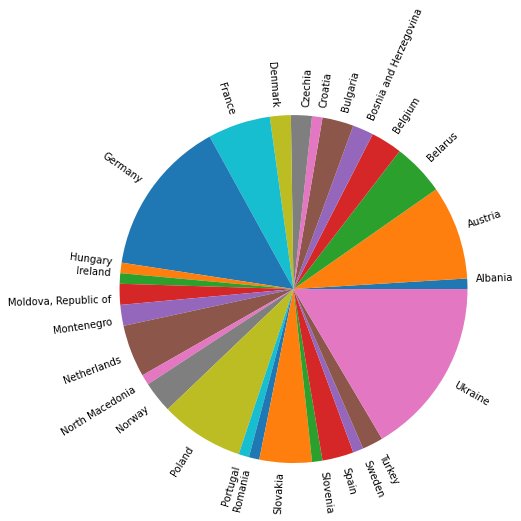

In [10]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']


node_comm = nodes_df.copy()
#node_comm.drop(columns=['NodeID'], inplace=True)
node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
node_comm['Quantity']=np.ones(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
node_comm = pd.merge(nodes2,node_comm,how='inner',on='Source')
node_comm.drop(columns=['lat','lng','admin_name','id'], inplace=True)
node_comm = node_comm[node_comm['country'].str.contains('|'.join(eu_countries))==True]
for i, set in enumerate(p):
    if(len(node_comm[node_comm['Community']==i].index)>3):
        display(node_comm[node_comm['Community']==i])


for i, set in enumerate(p):
    if(len(node_comm[node_comm['Community']==i].index)>100):
        com_df = node_comm[node_comm['Community']==i]
        label = com_df.groupby(['country']).sum().index.get_level_values('country').tolist()
        com_df = com_df.groupby(['country']).sum()
        #display(com_df)
        values = com_df['Quantity']
        #com_df = com1_df['Quantity']/1318*100
        plt.pie(values,labels= label, labeldistance=1.05,radius=2, rotatelabels=True)
        plt.show()

# 52 communities. Choose if it makes sense to reduce the number of them 


percentage of foreign languages speaker in europe

In [11]:
language_df = pd.read_csv('data\edat_aes_l26_1_Data.csv', sep=',',low_memory=False, header=0, encoding='utf8')
lan_df = language_df[language_df['TIME']==2016]
l = language_df[language_df['TIME']==2007]
l = l[l['GEO']=='Turkey']
lan_df = lan_df.append(l)
lan_df = lan_df[lan_df['DEG_URB']=='Cities']
lan_df = lan_df[~lan_df['N_LANG'].str.contains('No language')]
lan_df.drop(columns=['TIME','DEG_URB','N_LANG','UNIT','Flag and Footnotes'], inplace= True)
lan_df['Value'] = pd.to_numeric(lan_df['Value'], errors='coerce')
lan_df = lan_df.groupby(['GEO']).sum()
lan_df

,Value
GEO,
Albania,55.0
Austria,93.7
Belgium,81.9
Bosnia and Herzegovina,50.9
Bulgaria,64.3
Croatia,83.2
Cyprus,93.0
Czechia,83.8
Denmark,96.7


In [12]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(uni19_df)

TypeError: 'frozenset' object is not callable